# Predict Future Sales

## How to

You don't have to do anything special, pretrained models are provided. Simply clone repo, run this notebook and enjoy. 

Can send result_lgb+lr.csv file for evaluation

## Requirements

Notebook was created in typical anaconda environment

Uncomment and run cell below. to install lightgbm (if needed)

In [1]:
# !pip install lightgbm

In [2]:
import pathlib
import json
import pandas as pd
import numpy as np
import random
from itertools import product
import gc
import tqdm.notebook as tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack
import pickle
from sklearn.model_selection import StratifiedKFold


## Utility methods

In [3]:
random.seed(0)
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True), train_data.shape[0]

def divide_df(all_data, train_size):
    if 'target' in all_data:
        return all_data.loc[:train_size-1], all_data.loc[train_size:].drop(['target'], axis=1)
    return all_data.loc[:train_size-1], all_data.loc[train_size:]

def get_result_df(predict):
    result = pd.DataFrame(data={'ID': range(0, 214200), 'item_cnt_month': predict})
    result['item_cnt_month'] = result['item_cnt_month'].clip(0, 20)
    return result

def get_mix(alpha, X):
    return (alpha * X[:,0]) + ((1-alpha) * X[:,1])

def get_best_alpha(X_train_level2, target):
    alphas_to_try = np.linspace(0, 1, 1001)
    max_r2 = 0
    best_alpha = 1
    
    for alpha in alphas_to_try:
        mix = get_mix(alpha, X_train_level2)
        r2 = r2_score(target, mix)
        if max_r2 < r2:
            max_r2 = r2
            best_alpha = alpha
    return best_alpha

# this factor is needed for pipeline testing, make < 1 to reduce amount of data in work
cv_fraction = 0.2
def get_items_subset(X_train): 
    item_set = X_train['item_id'].unique()
    #random.shuffle(item_set)
    l = int(len(item_set) * cv_fraction)
    cv_item_set = item_set[:l]
    return X_train['item_id'].isin(cv_item_set)

## Data read

In [4]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
df_shops = pd.read_csv('shops.csv')
df_items = pd.read_csv('items.csv')
df_item_cats = pd.read_csv('item_categories.csv')

## Feature engineering

In [5]:
# removing item_cnt_day outliers
def remove_outlier(df_train, col):
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_train[col] > Q3+1.5*IQR)
    df_train[outliers].shape
    df_train.drop(df_train[outliers].index, inplace=True)
remove_outlier(df_train, 'item_cnt_day')
remove_outlier(df_train, 'item_price')

In [6]:
# ADD MONTH

df_train['month'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y').dt.month
# TODO add week, then add mean by week?

# FIX SHOPS

# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

In [7]:
# Create igem categories and cities from shops

# Extract type and sub type code
df_item_cats['split'] = df_item_cats['item_category_name'].str.split('-')
df_item_cats['type'] = df_item_cats['split'].map(lambda x: x[0].strip())
df_item_cats['type_code'] = LabelEncoder().fit_transform(df_item_cats['type'])
# if subtype is nan then type
df_item_cats['subtype'] = df_item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_cats['subtype_code'] = LabelEncoder().fit_transform(df_item_cats['subtype'])
df_item_cats = df_item_cats[['item_category_id','type_code', 'subtype_code']]

# Extract city
df_shops.loc[df_shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

# add distance to Moscow


df_shops['city_code'] = LabelEncoder().fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id','city_code']]

In [8]:
# Processing text features

df_items_txt = df_items[['item_id', 'item_name']]
df_items_txt['item_name'] = df_items_txt['item_name'].replace('[0-9!"\?\.)(,\+\*\[\]/:\-\'&]', ' ', regex=True)

features = 10
tfidf = TfidfVectorizer(max_features=features)
df_items_txt['item_name_len'] = df_items_txt['item_name'].map(len)  
df_items_txt['item_name_wc'] = df_items_txt['item_name'].map(lambda x: len(str(x).split(' '))) 
txtFeatures = pd.DataFrame(tfidf.fit_transform(df_items_txt['item_name']).toarray())
cols = txtFeatures.columns

for i in range(features):
    df_items_txt['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

df_items_txt.drop(columns=['item_name'], inplace=True)


C:\Users\Anton_Markov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Prepare mean encodings

In [9]:
sales = df_train.copy()
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
gb.rename(columns={'item_cnt_day': 'target'}, inplace=True)

# Fix column names
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
gb.rename(columns={'item_cnt_day': 'target_shop'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
gb.rename(columns={'item_cnt_day': 'target_item'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

df_test_concat = df_test.drop(columns=['ID'])
df_test_concat['date_block_num'] = 34
all_data, TRAIN_SIZE = concat_df(all_data, df_test_concat)

all_data = downcast_dtypes(all_data)
del grid, gb, df_test_concat, sales
gc.collect();

#### Prepare historical lags item

In [10]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm.tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# try to delete medians
all_data.drop(columns=['target_shop', 'target_item'], inplace=True)

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = df_items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = pd.merge(all_data, df_item_cats, how='left', on='item_category_id')
all_data = pd.merge(all_data, df_shops, how='left', on='shop_id')
all_data = pd.merge(all_data, df_items_txt, how='left', on='item_id')

all_data = downcast_dtypes(all_data)
del df_items_txt
gc.collect();

## Prepare train/validation validation sets

In [11]:
from sklearn.preprocessing import OneHotEncoder

def trim_12(df):
    return df[df['date_block_num'] >= 12]

def split_train_and_postprocess_for_linear(X_train, Y_train, X_test):
    Y_train = Y_train.reset_index(drop=True)
    
    df_all_data, train_size = concat_df(X_train, X_test)
    cat_columns = ['item_id', 'shop_id', 'item_category_id', 'type_code', 'subtype_code','city_code']
    for cat_column in cat_columns:
        df_all_data[cat_column] = df_all_data[cat_column].astype('category')
             
    df_cat = df_all_data[cat_columns + ['date_block_num']]
    df_scale = df_all_data[list(set(df_all_data.columns) - set(cat_columns))]
      
    scaler = StandardScaler()
    scaler.fit(df_scale)
    
    encoder = OneHotEncoder(drop='first')
    encoder.fit(df_cat[cat_columns])
    
    train_cat, X_test_cat = divide_df(df_cat, train_size)
    X_test_cat = X_test_cat.drop(columns=['date_block_num'])
    
    max_date = train_cat['date_block_num'].max()
               
    cv_X_test_cat = train_cat[train_cat['date_block_num'] == max_date].drop(columns=['date_block_num'])
    cv_X_train_cat = train_cat[train_cat['date_block_num'] < max_date].drop(columns=['date_block_num'])
    
    train_scale, X_test_scale = divide_df(df_scale, train_size)
    cv_X_test_scale = train_scale[train_scale['date_block_num'] == max_date]
    cv_Y_test = Y_train[train_scale['date_block_num'] == max_date]
    
    cv_Y_train = Y_train[train_scale['date_block_num'] < max_date]
    cv_X_train_scale = train_scale[train_scale['date_block_num'] < max_date]
               
    # scaling
    X_test_scale = scaler.transform(X_test_scale)
    cv_X_test_scale = scaler.transform(cv_X_test_scale)
    cv_X_train_scale = scaler.transform(cv_X_train_scale)
    
    X_test_cat = encoder.transform(X_test_cat)
    X_test_scale = csr_matrix(X_test_scale)
    X_test = hstack((X_test_cat, X_test_scale))
               
    cv_X_test_cat = encoder.transform(cv_X_test_cat)
    cv_X_test_scale = csr_matrix(cv_X_test_scale)
    cv_X_test = hstack((cv_X_test_cat, cv_X_test_scale))
    
    cv_X_train_cat = encoder.transform(cv_X_train_cat)    
    cv_X_train_scale = csr_matrix(cv_X_train_scale)
    cv_X_train = hstack((cv_X_train_cat, cv_X_train_scale))
               
    return cv_X_train, cv_Y_train, cv_X_test, cv_Y_test,X_test

def preprocess_for_linear(X_train, X_test):
    df_all_data, train_size = concat_df(X_train, X_test)
    cat_columns = ['item_id', 'shop_id', 'item_category_id', 'type_code', 'subtype_code','city_code']
    for cat_column in cat_columns:
        df_all_data[cat_column] = df_all_data[cat_column].astype('category')
            
    df_cat = df_all_data[cat_columns]
    df_scale = df_all_data[list(set(df_all_data.columns) - set(cat_columns))]
      
    scaler = StandardScaler()
    scaler.fit(df_scale)
    
    encoder = OneHotEncoder(drop='first')
    encoder.fit(df_cat)
    
    train_cat, X_test_cat = divide_df(df_cat, train_size)
    train_scale, X_test_scale = divide_df(df_scale, train_size)
               
    # scaling
    X_test_scale = scaler.transform(X_test_scale)
    X_test_cat = encoder.transform(X_test_cat)
    X_test = hstack((X_test_cat, X_test_scale))
    
    train_cat = encoder.transform(train_cat)
    train_scale = scaler.transform(train_scale)
    X_train = hstack((train_cat, train_scale))
               
    return X_train, X_test
               
def train_and_predict_lr(X, Y, X_test, model_name):
    pkl_filename = f'{model_name}.pkl'
    if pathlib.Path(pkl_filename).exists():
        print(f'Reading model {pkl_filename} from file')
        with open(pkl_filename, 'rb') as file:
            lr = pickle.load(file)
    else:
        lr = LinearRegression()
        lr.fit(X, Y)
        print(f'Storing model {pkl_filename} in file')
        with open(pkl_filename, 'wb') as file:
            pickle.dump(lr, file)
    pred_lr = lr.predict(X_test)
    return pred_lr

In [12]:
train, X_test = divide_df(all_data, TRAIN_SIZE)

# Don't use old data from year 2013
train = trim_12(train) 

item_ids_subset = get_items_subset(train)
train = train[item_ids_subset]

X_train = train.drop(columns=['target'])
Y_train = train['target']

max_date = X_train['date_block_num'].max()

# IMPORTANT this is holdout validation test set
cv_X_test = X_train[X_train['date_block_num'] == max_date]
cv_Y_test = Y_train[X_train['date_block_num'] == max_date]

cv_Y_train = Y_train[X_train['date_block_num'] < max_date]
cv_X_train = X_train[X_train['date_block_num'] < max_date]

del train, df_train
gc.collect();

#### Train lightgbm model with HP optimization and prediction
to speedup review we are storing optimized hyperparams, model training should not take much time

In [13]:
def optimize_lgb_parameters(X, Y, X_val, Y_val):
    
    if pathlib.Path('lgb_parameters.json').exists():
        with open('lgb_parameters.json') as f:
            params = json.load(f)
            print('Lgbm parameters read from file.')
            print(params)
        return params
    else:
        print('Lgbm HP optimization...')
        lgb_params ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
        fit_params={"early_stopping_rounds":30, 
                    "eval_metric" : 'rmse', 
                    "eval_set" : [(X_val, Y_val)],
                    'eval_names': ['valid'],
                    'verbose': 100,
                    'categorical_feature': 'auto'}
        
        n_HP_points_to_test = 50
        
        clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, 
                                n_estimators=50)
        gs = RandomizedSearchCV(
            estimator=clf, param_distributions=lgb_params, 
            n_iter=n_HP_points_to_test,
            scoring='r2',
            cv=4,
            refit=True,
            random_state=314,
            verbose=False)
        gs.fit(X, Y, **fit_params)
        print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
        params = gs.best_params_
        with open('lgb_parameters.json', 'w') as f:
            json.dump(params, f)
        return params

def train_and_predict_lgbm(X, Y, X_test, params, model_name):
    model_file = f'{model_name}.txt'
    if pathlib.Path(model_file).exists():
        print(f'reading lgb model {model_name} from file')
        model = lgb.Booster(model_file=model_file)
    else:
        print(f'training {model_name} by parameters')
        model = lgb.train(params, lgb.Dataset(X, label=Y), 100)
        model.save_model(model_file)
        
    pred_lgb = model.predict(X_test)
    return pred_lgb 

## Final train/validation/prediction setup

In [14]:
# ROUND I 
# FINDING OPTIMAL PARAMETERS AND PARAMETER ALPHA FOR MIXING UP RESULTS OF LBG AND LINEAR MODELS

lgb_parameters = optimize_lgb_parameters(cv_X_train, cv_Y_train, cv_X_test, cv_Y_test)

# Use holdout validation test set to find optimal alpha

pred_tree = train_and_predict_lgbm(cv_X_train, cv_Y_train, cv_X_test, lgb_parameters, 'lgb_model_validation')
lgb_r2 = r2_score(cv_Y_test, pred_tree)
lgb_rmse = mean_squared_error(cv_Y_test, pred_tree, squared=False)

cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, cv_Y_test_lr, X_test_lr \
    = split_train_and_postprocess_for_linear(X_train, Y_train, X_test)

pred_lr = train_and_predict_lr(cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, 'lr_model_full')
lr_r2 = r2_score(cv_Y_test_lr, pred_lr)
lr_rmse = mean_squared_error(cv_Y_test_lr, pred_lr, squared=False)

X_train_level2 = np.c_[pred_tree, pred_lr]

best_alpha = get_best_alpha(X_train_level2, cv_Y_test)
mix = get_mix(best_alpha, X_train_level2)
mix_r2 = r2_score(cv_Y_test, mix)
mix_rmse = mean_squared_error(cv_Y_test, mix, squared=False)

results = {'cv_fraction':cv_fraction, 
           'lr_rmse': lr_rmse, 'lr_r2': lr_r2, 
           'lgb_rmse': lgb_rmse, 'lgb_r2': lgb_r2, 
           'mix_rmse': mix_rmse, 'mix_r2': mix_r2, 
           'alfa': best_alpha}
print(results)

Lgbm HP optimization...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.489786
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490467
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.492353
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.492145
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.488989
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.489601
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.491873
Training until va

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.487728
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.489498
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490484
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490344
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.492692
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.493411
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.495078
Training until validation scores don't im

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490606
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.49033
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.492729
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.491375
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.488503
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.489545
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.491178
Training until validation scores don't imp

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490224
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490546
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.492464
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.492696
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.490577
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.491408
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.493223
Training until validation scores don't im

In [15]:
# Store and display validation metruics results
results_metrics = 'results_metrics.csv'
columns=['lr_rmse', 'lr_r2', 'lgb_rmse', 'lgb_r2', 'mix_rmse', 'mix_r2', 'alfa']

if pathlib.Path(results_metrics).exists():
    metrics = pd.read_csv(results_metrics)
else:
    metrics = pd.DataFrame(columns=['cv_fraction'] + columns)

metrics = pd.concat([metrics, pd.DataFrame(results, index=[len(metrics)+1])])   
metrics.to_csv(results_metrics, index=False)

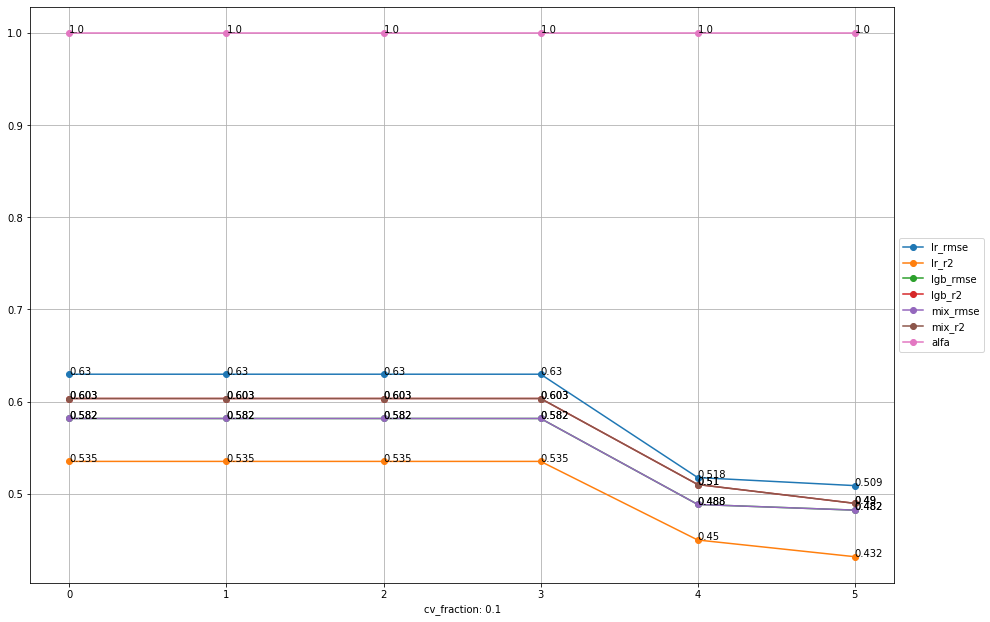

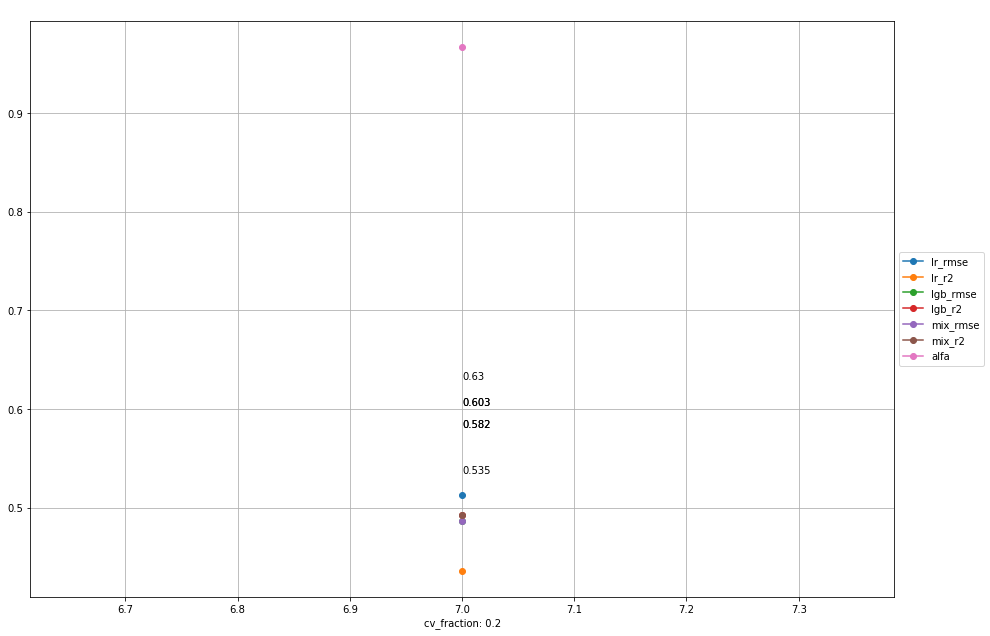

In [18]:

for cv_fraction in metrics['cv_fraction'].unique():
    ax =plt.axes([0, 0, 2, 2])
    for col in columns:
        sub_metrix = metrics[metrics['cv_fraction'] == cv_fraction]
        ax.plot(sub_metrix.index, sub_metrix[col], marker='.', linestyle='-', ms=12, label=col)
        for i,j in zip(sub_metrix.index,metrics[col]):
            ax.annotate(str(round(j,3)),xy=(i,j))
        plt.xlabel(f'cv_fraction: {cv_fraction}')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    plt.show()


# ROUND II
# TRAIN MODELS ON COMPLETE DATA SET AND GETTING PREDICTIONS FOR SUBMITING
X_train_lr, X_test_lr = preprocess_for_linear(X_train, X_test)
pred_tree = train_and_predict_lgbm(X_train, Y_train, X_test, lgb_parameters, 'lgb_model_train')
pred_lr = train_and_predict_lr(X_train_lr, Y_train, X_test_lr, 'lr_model_full')

X_train_level2 = np.c_[pred_tree, pred_lr]

result = get_mix(best_alpha, X_train_level2)

get_result_df(result).to_csv('result_lgb+lr.csv', index=False)
# Your public and private LB scores are: 0.962927 and 0.963253.
get_result_df(pred_tree).to_csv('result_lgb.csv', index=False)
print("DONE!")


## Result
you can send result_lgb+lr.csv file for evaluation